This notebook shows how to do spatial interpolation in R.

Install the packages from terminal before loading them. Launch R. Then in R console:

```R
install.packages(c('sp', 'gstat', 'dplyr', 'ggplot2', 'scales', 'magrittr', 'gridExtra'))

```

In [1]:
# load libraries
library(sp)     # to handle spatial objects
library(gstat)  # to do kriging


# other packages for plotting and such
library(dplyr) # for "glimpse"
library(ggplot2)
library(scales) # for "comma"
library(magrittr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
data(meuse)   # data meuse comes with sp package
str(meuse)
glimpse(meuse)

'data.frame':	155 obs. of  14 variables:
 $ x      : num  181072 181025 181165 181298 181307 ...
 $ y      : num  333611 333558 333537 333484 333330 ...
 $ cadmium: num  11.7 8.6 6.5 2.6 2.8 3 3.2 2.8 2.4 1.6 ...
 $ copper : num  85 81 68 81 48 61 31 29 37 24 ...
 $ lead   : num  299 277 199 116 117 137 132 150 133 80 ...
 $ zinc   : num  1022 1141 640 257 269 ...
 $ elev   : num  7.91 6.98 7.8 7.66 7.48 ...
 $ dist   : num  0.00136 0.01222 0.10303 0.19009 0.27709 ...
 $ om     : num  13.6 14 13 8 8.7 7.8 9.2 9.5 10.6 6.3 ...
 $ ffreq  : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
 $ soil   : Factor w/ 3 levels "1","2","3": 1 1 1 2 2 2 2 1 1 2 ...
 $ lime   : Factor w/ 2 levels "0","1": 2 2 2 1 1 1 1 1 1 1 ...
 $ landuse: Factor w/ 15 levels "Aa","Ab","Ag",..: 4 4 4 11 4 11 4 2 2 15 ...
 $ dist.m : num  50 30 150 270 380 470 240 120 240 420 ...
Observations: 155
Variables: 14
$ x       <dbl> 181072, 181025, 181165, 181298, 181307, 181390, 181165, 181...
$ y       <dbl> 3336

In [3]:
?meuse

Each chemical taken from the Meuse river in the Netherlands varies with geographic coordinates which are the `x`- and `y`- columns.

For example, we can plot how lead concentration varies with geographical location:

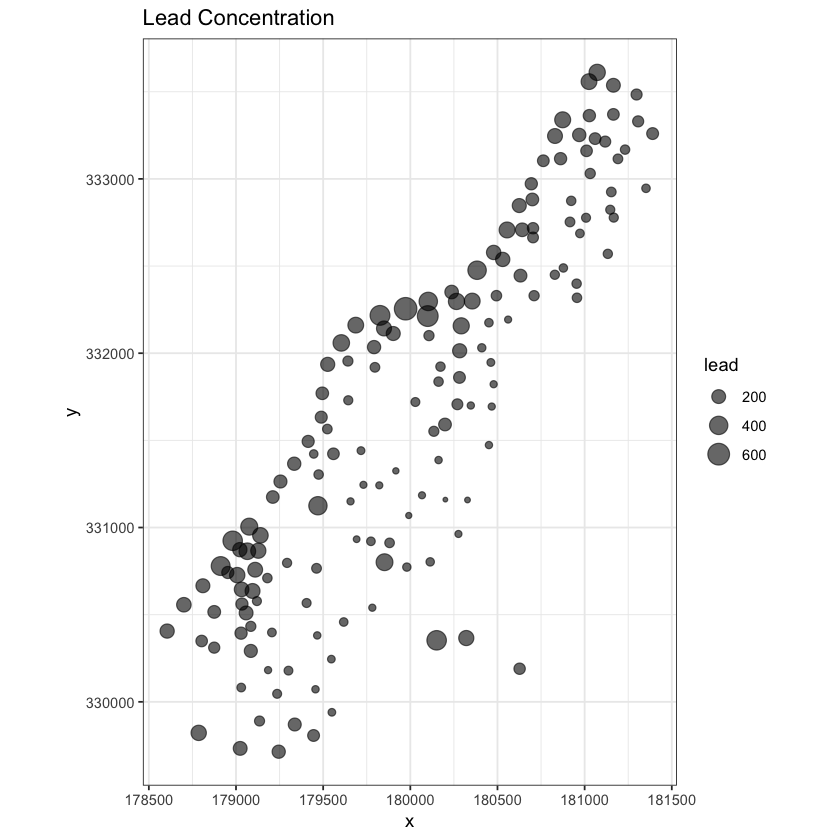

In [4]:
meuse %>% as.data.frame %>% 
  ggplot(aes(x, y)) + geom_point(aes(size = lead), color="black", alpha=0.6) + 
  ggtitle("Lead Concentration") + coord_equal() + theme_bw()

Let's krige the concentration of lead where we do not have measurements:

- convert the dataframe to a spatial points dataframe (SPDF)
- fit a variogram model to the data
- krige the data according to the variogram

In [5]:
class(meuse)

[1] "data.frame"

To convert it to a spatial dataframe, we specify which of the columns contain the coordinates of the data:

In [6]:
summary(meuse$lead)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   37.0    72.5   123.0   153.4   207.0   654.0 

In [7]:
coordinates(meuse) <- ~ x + y
class(meuse)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

In [8]:
str(meuse)

Formal class 'SpatialPointsDataFrame' [package "sp"] with 5 slots
  ..@ data       :'data.frame':	155 obs. of  12 variables:
  .. ..$ cadmium: num [1:155] 11.7 8.6 6.5 2.6 2.8 3 3.2 2.8 2.4 1.6 ...
  .. ..$ copper : num [1:155] 85 81 68 81 48 61 31 29 37 24 ...
  .. ..$ lead   : num [1:155] 299 277 199 116 117 137 132 150 133 80 ...
  .. ..$ zinc   : num [1:155] 1022 1141 640 257 269 ...
  .. ..$ elev   : num [1:155] 7.91 6.98 7.8 7.66 7.48 ...
  .. ..$ dist   : num [1:155] 0.00136 0.01222 0.10303 0.19009 0.27709 ...
  .. ..$ om     : num [1:155] 13.6 14 13 8 8.7 7.8 9.2 9.5 10.6 6.3 ...
  .. ..$ ffreq  : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ soil   : Factor w/ 3 levels "1","2","3": 1 1 1 2 2 2 2 1 1 2 ...
  .. ..$ lime   : Factor w/ 2 levels "0","1": 2 2 2 1 1 1 1 1 1 1 ...
  .. ..$ landuse: Factor w/ 15 levels "Aa","Ab","Ag",..: 4 4 4 11 4 11 4 2 2 15 ...
  .. ..$ dist.m : num [1:155] 50 30 150 270 380 470 240 120 240 420 ...
  ..@ coords.nrs : int [1:2] 1 

In [9]:
# access various slots of the SPDF
meuse@bbox  # the bounding box which denotes the spatial extent of the data

,min,max
x,178605,181390
y,329714,333611


In [10]:
glimpse( meuse@coords )

 num [1:155, 1:2] 181072 181025 181165 181298 181307 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:155] "1" "2" "3" "4" ...
  ..$ : chr [1:2] "x" "y"


Next, we calculate the sample variogram with the `variogram` function. Then, we fit a model to the sample variogram.

In [11]:
?variogram

In [12]:
# The variogram function can take two arguments: 
# the first specifies how one or more variables interact spatially,
# the second is the data (should be SPDF class)
# use z ~ 1 in case of absence of regressors

lzn.vgm <- variogram(lead ~ 1, meuse) # calculates sample variogram values 

In [13]:
# In this function, you can specify anisotropy with say anis = c(30, 0.5)
# nugget or no nugget
# and other parameters
# can make it a lot more complex
# for example, model = vgm(psill = 1, model = "Sph", range = 900, nugget = 1, anis = c(30, 10, 0, 0.5, 0.3))
?vgm

In [14]:
# For the fit.variogram function, 
# a sample variogram is the first argument, 
# the second argumnet is the model with parameters, to be fit to the sample variogram. 

lzn.fit <- fit.variogram(lzn.vgm, model=vgm(psill = 1, model = "Sph", range = 900, nugget = 1)) # fit model

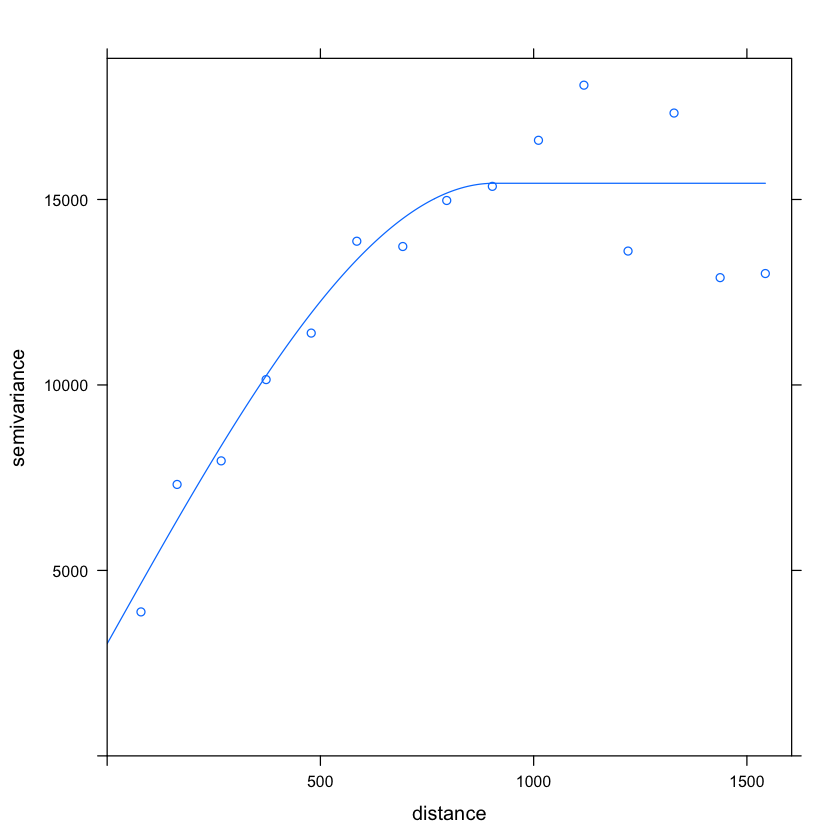

In [15]:
# plot the sample and fit variogram to see how good the fit is:
plot(lzn.vgm, lzn.fit)

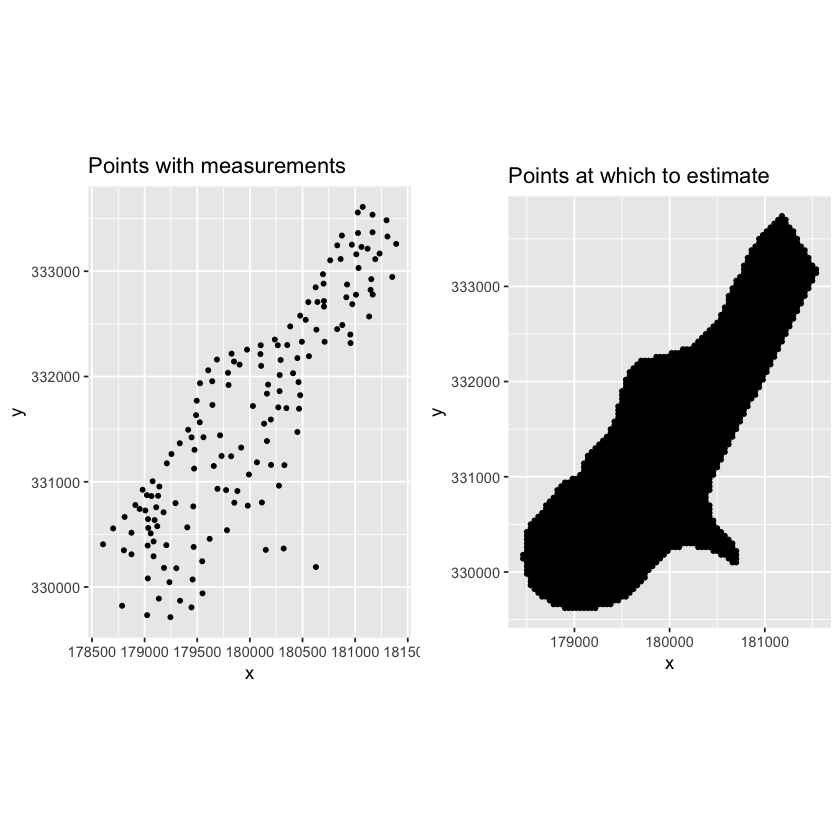

In [16]:
# load spatial domain to interpolate over
data("meuse.grid")

# the first grid (meuse) is for points for which we have data
plot1 <- meuse %>% as.data.frame %>%
  ggplot(aes(x, y)) + geom_point(size=1) + coord_equal() + 
  ggtitle("Points with measurements")

# the second grid (meuse.grid) is where we want to estimate the values of zinc
plot2 <- meuse.grid %>% as.data.frame %>%
  ggplot(aes(x, y)) + geom_point(size=1) + coord_equal() + 
  ggtitle("Points at which to estimate")

# from gridExtra package
grid.arrange(plot1, plot2, ncol = 2)

### Kriging
The `krige` function from `gstat` package takes four arguments:
- model formula
- SPDF of the spatial domain that has measurements
- SPDF of the spatial domain to krige over
- variogram model fitted to the data

In [17]:
# convert from data.frame to SPDF for the spatial domain to krige over
coordinates(meuse.grid) <- ~ x + y 

In [18]:
?krige

In [19]:
lzn.kriged <- krige(formula = lead ~ 1, locations = meuse, newdata = meuse.grid, model = lzn.fit)

[using ordinary kriging]


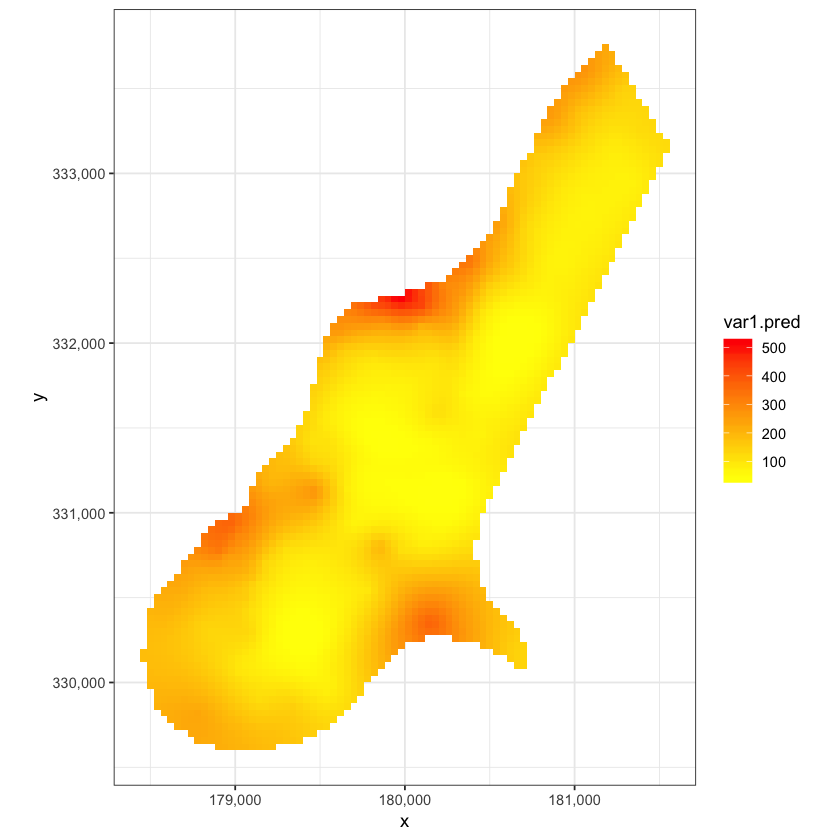

In [20]:
# visualize the results
# var1.pred is the predicted measurement for the variable being interpolated
lzn.kriged %>% as.data.frame %>%
  ggplot(aes(x=x, y=y)) + geom_tile(aes(fill=var1.pred)) + coord_equal() +
  scale_fill_gradient(low = "yellow", high="red") +
  scale_x_continuous(labels=comma) + scale_y_continuous(labels=comma) +
  theme_bw()

In [21]:
# lzn.kriged als contains the variance of each prediction 
lzn.kriged$var1.var

[1]  9148.839  7803.470  8195.795  8637.695  6362.993  6785.636  7265.852
   [8]  7757.675  5051.236  5339.579  5920.515  6406.765  6911.456  7422.923
  [15]  5052.387  4826.969  5046.688  5307.845  5615.032  6136.163  6620.281
  [22]  7102.841  5835.815  5008.626  5026.241  5123.633  4936.822  4933.092
  [29]  5566.881  5899.346  6220.717  6567.263  5970.596  5536.494  5400.643
  [36]  5344.946  5183.632  5166.833  5375.148  5355.579  5243.341  6149.949
  [43]  6358.163  5968.971  5689.502  5564.116  5491.881  5396.290  5364.401
  [50]  5386.434  5271.564  5183.065  5892.419  6267.394  6001.619  5716.012
  [57]  5469.200  5421.400  5408.525  5285.486  5248.296  5355.467  5383.931
  [64]  5462.351  5874.294  6566.193  5827.873  5597.319  5564.446  5327.002
  [71]  4897.651  5081.552  5215.769  4958.084  4849.163  5239.073  5315.675
  [78]  5314.216  5639.020  6255.375  7014.789  4987.986  5004.437  5225.158
  [85]  5106.145  4821.041  4994.615  5159.212  5050.716  5037.652  5253.155
  [92]  5181.461  4785.420  5224.265  5850.247  6583.157  5479.224  5018.110
  [99]  4991.487  5018.424  4945.642  4939.979  5006.959  5119.628  5201.633
 [106]  5294.984  5367.435  5261.309  5015.958  5127.951  5401.876  6094.245
 [113]  7144.651  4959.013  4908.699  5019.020  4811.682  4548.452  4745.075
 [120]  4693.499  4836.418  5047.109  5269.134  5375.658  5385.417  5342.113
 [127]  5255.499  4949.026  5783.563  7004.769  5683.513  5029.598  4991.361
 [134]  5092.272  4929.289  4705.613  4632.080  4383.431  4474.641  4715.719
 [141]  5066.697  5159.662  5308.267  5501.932  5583.499  5654.491  6228.438
 [148]  7207.803  8245.507  5539.389  5196.863  5098.966  5155.695  5096.194
 [155]  4811.609  4567.778  4728.906  4769.832  4834.343  4873.442  4684.300
 [162]  5062.951  5606.808  5955.257  6280.046  6808.783  7579.555  8471.271
 [169]  9389.884  5166.620  5023.783  4838.717  5087.582  5200.614  4975.219
 [176]  4763.389  5001.302  5100.188  5003.888  4713.480  4703.654  5183.157
 [183]  5783.326  6249.842  6685.247  7222.251  7909.813  8709.177  9558.194
 [190]  5180.550  4828.325  4988.445  4804.063  5170.748  5357.875  5251.523
 [197]  5121.269  5194.093  5288.197  5176.019  4813.191  5029.240  5526.736
 [204]  5998.221  6430.043  6884.746  7438.373  8115.714  8888.285  5826.880
 [211]  5375.088  5252.848  5348.135  5406.536  5522.310  5546.578  5342.820
 [218]  5020.128  5119.435  5369.664  5417.498  5375.773  5513.119  5805.721
 [225]  6108.991  6432.575  6866.080  7459.217  8186.092  8991.199  5469.830
 [232]  5420.246  5548.994  5688.738  5769.692  5789.076  5700.958  5418.423
 [239]  4900.786  5073.521  5403.285  5520.827  5601.162  5747.303  5911.385
 [246]  6030.573  6191.552  6610.040  7313.881  8158.070  5416.281  4788.168
 [253]  5275.828  5640.974  5846.150  5905.223  5862.101  5759.123  5589.950
 [260]  5395.553  5372.769  5403.931  5371.043  5488.844  5725.749  5861.182
 [267]  5801.187  5672.668  6149.172  7113.658  8126.258  5195.991  4874.861
 [274]  5228.718  5645.249  5854.214  5838.178  5691.827  5605.196  5614.842
 [281]  5599.397  5520.687  5308.485  4912.466  5135.010  5603.946  5814.098
 [288]  5707.966  5258.219  5927.247  7121.586  5446.520  4963.260  4688.524
 [295]  5169.604  5625.713  5795.221  5654.384  5269.718  5159.126  5437.734
 [302]  5568.743  5509.470  5248.004  4888.001  5077.003  5572.360  5899.327
 [309]  6001.652  6055.978  6572.390  7513.315  4833.713  4776.606  4770.199
 [316]  5239.960  5642.700  5750.945  5535.909  5034.695  4878.056  5231.653
 [323]  5398.278  5387.607  5155.830  4873.396  5074.866  5595.754  6076.792
 [330]  6436.393  6788.821  7331.305  4937.891  4932.965  5120.475  5413.435
 [337]  5680.027  5729.816  5509.212  5154.910  4993.236  5012.823  5086.016
 [344]  5199.455  5014.964  4458.410  4858.339  5599.833  6282.348  6853.295
 [351]  7388.794  7991.112  5397.283  5081.934  4999.624  5108.543  5379.340
 [358]  5645.861  5692.630  5433.811  4960.138  4794.039  4711.718  4640.222